# 日経平均株価 15分足

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import get_name_15min_chart, get_name_15min_chart_usd

In [3]:
code = "N225"
symbol = f"^{code}"
yticker = yf.Ticker(symbol)
df = yticker.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-02-12 09:00:00+09:00,57864.738281,57994.890625,57814.488281,57966.671875,0,0.0,0.0
2026-02-12 09:15:00+09:00,57971.519531,58004.718750,57703.878906,57884.011719,0,0.0,0.0
2026-02-12 09:30:00+09:00,57893.308594,58013.859375,57836.070312,57985.609375,0,0.0,0.0
2026-02-12 09:45:00+09:00,57992.550781,58015.078125,57893.199219,57921.851562,0,0.0,0.0
2026-02-12 10:00:00+09:00,57926.421875,57947.429688,57849.968750,57849.968750,0,0.0,0.0
2026-02-12 10:15:00+09:00,57860.269531,57860.269531,57751.941406,57781.441406,0,0.0,0.0
2026-02-12 10:30:00+09:00,57781.078125,57850.800781,57640.601562,57662.609375,0,0.0,0.0
2026-02-12 10:45:00+09:00,57667.121094,57690.960938,57580.238281,57676.390625,0,0.0,0.0
2026-02-12 11:00:00+09:00,57673.191406,57728.699219,57620.949219,57627.511719,0,0.0,0.0


In [4]:
dt_start = df.index[0]
dt_end = pd.to_datetime(
    f"{dt_start.year:04d}-{dt_start.month:02d}-{dt_start.day:02d} 15:30:00+09:00"
).tz_convert("Asia/Tokyo")
dt_start, dt_end

(Timestamp('2026-02-12 09:00:00+0900', tz='Asia/Tokyo'),
 Timestamp('2026-02-12 15:30:00+0900', tz='Asia/Tokyo'))

In [5]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = yticker.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 50168.11 # 12/15 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2026-02-05 00:00:00+09:00    53818.039062
2026-02-06 00:00:00+09:00    54253.679688
2026-02-09 00:00:00+09:00    56363.941406
2026-02-10 00:00:00+09:00    57650.539062
2026-02-12 00:00:00+09:00    57813.800781
Name: Close, dtype: float64


Date
2026-02-10 00:00:00+09:00    57650.539062
Name: Close, dtype: float64

In [6]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+214.20


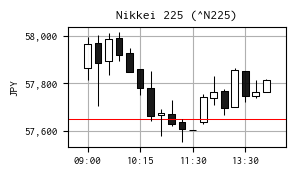

In [7]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in yticker.info:
    ax.set_title(f"{yticker.info['shortName']} ({symbol})")
elif "longName" in yticker.info:
    ax.set_title(f"{yticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

In [8]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

In [9]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-02-11 09:00:00+09:00,154.496994,154.516998,154.384003,154.451004,0,0.0,0.0
2026-02-11 09:15:00+09:00,154.440994,154.468002,154.240997,154.279999,0,0.0,0.0
2026-02-11 09:30:00+09:00,154.268997,154.279999,154.063004,154.074997,0,0.0,0.0
2026-02-11 09:45:00+09:00,154.076004,154.115005,153.985992,154.048004,0,0.0,0.0
2026-02-11 10:00:00+09:00,154.042007,154.050995,153.871002,153.914001,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-02-12 13:15:00+09:00,152.494995,152.684006,152.468002,152.612000,0,0.0,0.0
2026-02-12 13:30:00+09:00,152.615997,152.748001,152.526001,152.720001,0,0.0,0.0
2026-02-12 13:45:00+09:00,152.722000,152.856995,152.682999,152.854996,0,0.0,0.0


In [10]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2026-02-12 09:00:00+09:00,377.222091,378.070558,376.894510,377.886599
2026-02-12 09:15:00+09:00,378.458538,378.675274,376.711285,377.887256
2026-02-12 09:30:00+09:00,377.629893,378.416229,377.256536,378.231958
2026-02-12 09:45:00+09:00,378.763964,378.911096,378.115074,378.302210
2026-02-12 10:00:00+09:00,378.873965,379.011369,378.373915,378.373915
2026-02-12 10:15:00+09:00,377.951831,377.951831,377.244215,377.436914
2026-02-12 10:30:00+09:00,377.802257,378.258140,376.883749,377.027648
2026-02-12 10:45:00+09:00,377.291509,377.447483,376.723071,377.352155
2026-02-12 11:00:00+09:00,377.753861,378.117432,377.411679,377.454663


In [11]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2026-02-11 15:15:00+09:00


np.float64(153.03599548339844)

前日終値（ドル換算） 376.71228184191483


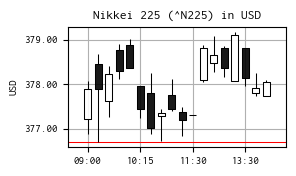

In [12]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in yticker.info:
    ax.set_title(f"{yticker.info['shortName']} ({symbol}) in USD")
elif "longName" in yticker.info:
    ax.set_title(f"{yticker.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()